In [7]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from finder import read_files, parse_annotated, target_classes
from label import Label

In [8]:
SEED=12345
default_label = Label('Misc-exposition')
keep_labels = [Label('Description'), Label('Nomenclature')]

In [9]:
training_files = [f for g in [
    '../data/annotated/journals/Mycotaxon/Vol*/*.ann'
] for f in glob.glob(g)]


In [13]:
len(training_files)

169

In [10]:
paragraphs = list(parse_annotated(read_files(training_files)))

In [11]:
relabeled = list(target_classes(default=default_label, keep=keep_labels, paragraphs=paragraphs))

In [16]:
print(len(relabeled), "paragraphs")
print(relabeled[:5])

79192 paragraphs
[Labels([Label('Misc-exposition')]), Paragraph('\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('ISSN (print) 0093-4666\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('© 2012. Mycotaxon, Ltd.\n'), Pending(None)
, Labels([Label('Misc-exposition')]), Paragraph('\n'), Pending(None)
]


In [34]:
pp=relabeled[2000]
dir(pp)
print(f"pp.filename: {pp.filename}")
print(f"pp.paragraph_number: {pp.paragraph_number}")
print(f"pp.top_label().label: {pp.top_label().label}")
print(f"pp.empirical_page_number: {pp.empirical_page_number}")
print(f"str(pp): {str(pp)}")
print(f"len(str(pp)): {len(str(pp))}")

pp.filename: ../data/annotated/journals/Mycotaxon/Vol119/s19.txt.ann
pp.paragraph_number: 2000
pp.top_label().label: Misc-exposition
pp.empirical_page_number: 4666
str(pp): There are 114 Mycena species so far recorded in Argentina. Most have been
found in the Andino-Patagonic forest and the Yungas region of northwestern
Argentina, with only six species known from the Paranaense forest (Spegazzini
1926, Wright et al. 2008, Lechner et al. 2006, Wright & Wright 2005, Niveiro
et al. 2010).

len(str(pp)): 318


In [22]:
df = pd.DataFrame({
    'filename': [pp.filename for pp in relabeled],
    'label': [pp.top_label().label if pp.top_label() else None for pp in relabeled],
    'paragraph_number': [pp.paragraph_number for pp in relabeled],
    'page_number': [pp.page_number for pp in relabeled],
    'empirical_page_number': [pp.empirical_page_number for pp in relabeled],
    'line_number': [pp.first_line.line_number if pp.first_line else None for pp in relabeled],
    'body': [str(pp) for pp in relabeled]
})
df.label = pd.Categorical(df.label)
df['label_code'] = df.label.cat.codes

In [24]:
df.describe()

,paragraph_number,page_number,line_number,label_code
count,79192.000000,79192.000000,79191.000000,79192.000000
mean,39595.500000,233.063415,31.672652,0.990479
std,22860.905596,192.882065,29.156364,0.319322
min,0.000000,0.000000,1.000000,0.000000
25%,19797.750000,24.000000,10.000000,1.000000
50%,39595.500000,216.000000,25.000000,1.000000
75%,59393.250000,416.000000,43.000000,1.000000
max,79191.000000,572.000000,292.000000,2.000000


In [25]:
df.keys()

Index(['filename', 'label', 'paragraph_number', 'page_number',
       'empirical_page_number', 'line_number', 'body', 'label_code'],
      dtype='object')

In [35]:
df.groupby('label').nunique()

/tmp/ipykernel_1713312/3741156644.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('label').nunique()


,filename,paragraph_number,page_number,empirical_page_number,line_number,body,label_code
label,,,,,,,
Description,149,4418,497,501,80,3014,1
Misc-exposition,169,71110,573,579,192,40173,1
Nomenclature,152,3664,437,449,83,3551,1


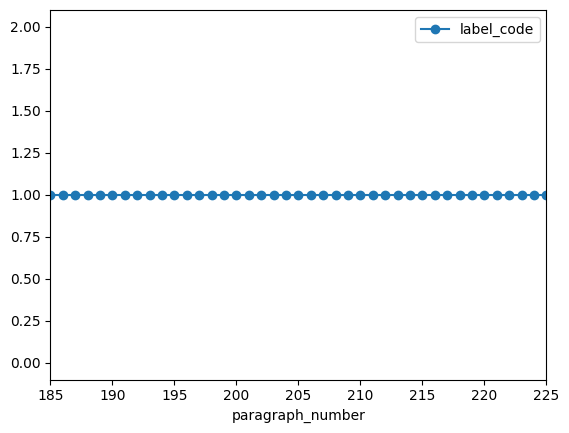

In [36]:
df.plot(kind='line', x='paragraph_number', y='label_code', style='-o')
x = 185
plt.xlim(x,x+40)
plt.show()

In [37]:
df.loc[187], df.loc[188], df.loc[194]

(filename                 ../data/annotated/journals/Mycotaxon/Vol119/s4...
 label                                                      Misc-exposition
 paragraph_number                                                       187
 page_number                                                              7
 empirical_page_number                                                  411
 line_number                                                           46.0
 body                     Singer R. 1976. Marasmieae (Basidiomycetes – T...
 label_code                                                               1
 Name: 187, dtype: object,
 filename                 ../data/annotated/journals/Mycotaxon/Vol119/s4...
 label                                                      Misc-exposition
 paragraph_number                                                       188
 page_number                                                              7
 empirical_page_number                                       

We're only interested in Nomeclature and Description paragraphs.

The long list of Nomenclatures followed by a single Nomenclature is an article with just Nomenclatures, and then the next article has a Nomenclature and two Descriptions.

In [38]:
df2 = df.loc[df['label'].isin(['Nomenclature', 'Description'])]
len(df2)

8082

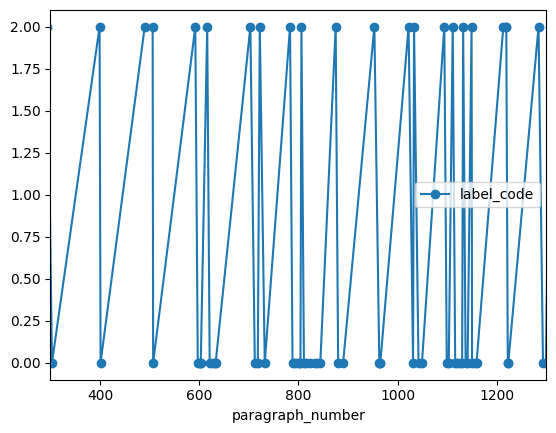

In [42]:
df2.plot(kind='line', x='paragraph_number', y='label_code', style='-o')
x = 300
plt.xlim(x,x+1000)
plt.show()

Sensible cutoffs for max distance from Nomenclature to Description appear to be above 6 or maybe above 13.

np.float64(6313.0)

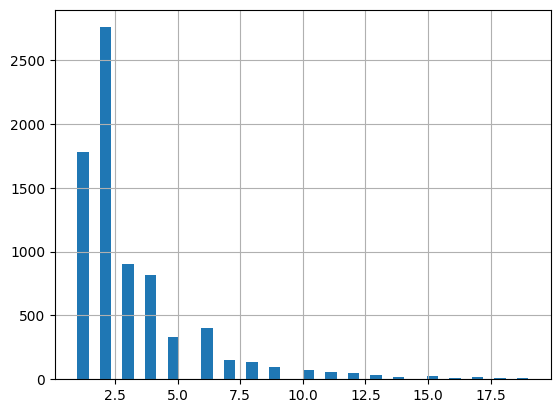

In [43]:
diffs = df2['paragraph_number'].diff()
diffs[diffs < 20].hist(bins=40)
diffs.max()

I have confirmed that the highest paragraph distance is the first nomenclature in a volume. The first and last few articles in Mycotaxon typically have no Nomenclatures.

In [16]:
df2.loc[diffs.index[diffs == 3958.0]]

,filename,label,paragraph_number,page_number,empirical_page_number,line_number,body,label_code
57414,data/annotated/journals/Mycotaxon/Vol057/n1.tx...,Nomenclature,57414,96,88,21.0,Appendiculella mauensis R. K. Mibey sp. nov. F...,2


In [17]:
df2.loc[57414]

filename                 data/annotated/journals/Mycotaxon/Vol057/n1.tx...
label                                                         Nomenclature
paragraph_number                                                     57414
page_number                                                             96
empirical_page_number                                                   88
line_number                                                             21
body                     Appendiculella mauensis R. K. Mibey sp. nov. F...
label_code                                                               2
Name: 57414, dtype: object